In [1]:
import sys, os
sys.path.append(os.path.abspath(
    os.getcwd()+"/core")
)

In [2]:
import jax.numpy as jnp
from jax import random, lax, nn, jit, vmap, value_and_grad, grad
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import optax
from time import time
from pymatching import Matching

from core.quantum_error_correction_code import SurfaceCode, deformation_cmap, relevancy_tensor
from core.neural_network import CNNDecoder, save_params
from core.perfect_maximum_likelihood_decoder import PMLD

In [3]:
BATCH_SIZE = 32
TRAINING_BATCHES = 200_000

CODE_DISTANCE = 3

INIT_LEARNING_RATE = 0
LEARNING_RATE = 1E-3
WARMUP_STEPS = 2_000
TRANSITION_STEP = 50_000
DECAY_RATE = 0.95

# Number of filters, Kernal size, Stride
NUM_FILTERS = CODE_DISTANCE**2-1
# NUM_FILTERS = int(2**jnp.ceil(jnp.log2(CODE_DISTANCE**2-1)))
CONV_LAYERS = [(NUM_FILTERS,2,1,0), (NUM_FILTERS,2,1,0)]
FC_LAYERS = [50, 2]
print(f"{NUM_FILTERS = }")

SEED = 16

# No deformation
# DEFORMATION = jnp.zeros(CODE_DISTANCE**2, dtype=jnp.int32)
# The XZZX deformation
# DEFORMATION = jnp.zeros(CODE_DISTANCE**2, dtype=jnp.int32).at[::2].set(3)
# The XY deformation
# DEFORMATION = jnp.zeros(CODE_DISTANCE**2, dtype=jnp.int32).at[:].set(2)
# The C1 deformation (extended)
DEFORMATION = jnp.zeros((CODE_DISTANCE, CODE_DISTANCE), dtype=jnp.int32).at[1::2, ::2].set(3).flatten().at[::2].set(2)

p, nu = .01, 500
ERROR_PROBS = jnp.array([
    1 / (2 * (nu + 1)) * p,
    1 / (2 * (nu + 1)) * p,
    nu / (nu + 1) * p,
])
ERROR_PROB_TRAINING_SCALE = 9

settings = {
    "CODE_DISTANCE": CODE_DISTANCE,
    "ERROR_PROBS": ERROR_PROBS,
    "CONV_LAYERS": CONV_LAYERS,
    "FC_LAYERS": FC_LAYERS,
}

NUM_FILTERS = 8


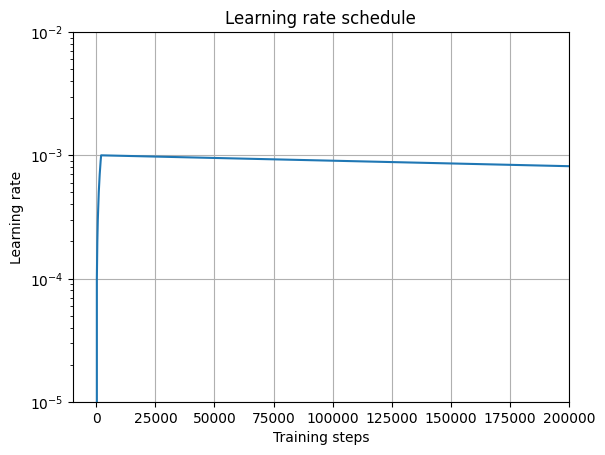

In [4]:
learning_rate = optax.warmup_exponential_decay_schedule(
    init_value=INIT_LEARNING_RATE,
    peak_value=LEARNING_RATE,
    warmup_steps=WARMUP_STEPS,
    transition_steps=TRANSITION_STEP,
    decay_rate=DECAY_RATE
)

step = jnp.linspace(0, TRAINING_BATCHES, 1000)

plt.figure()
plt.plot(step, learning_rate(step))
plt.yscale('log')
plt.title("Learning rate schedule")
plt.xlabel("Training steps")
plt.ylabel("Learning rate")
plt.grid()
plt.xlim(xmax=TRAINING_BATCHES)
plt.ylim(1E-5, 1E-2)
plt.show()

optimizer = optax.adam(learning_rate)

In [5]:
def train(
    random_seed: int,
    code: SurfaceCode,
    probabilities: jnp.ndarray,
    optimizer: optax.GradientTransformation,
    model: CNNDecoder
):
    @jit
    def loss_fn(
        model_params,
        x: jnp.ndarray,
        y: jnp.ndarray,
    ):
        """
        Loss function for the model. The loss is the binary cross-entropy (BCE) between the model's output and the target labels.

        Args:
            model_params: Parameters of the model.
            x1: First input to the model (syndrome images).
            x2: Second input to the model (deformation images).
            y: Target labels.
        Returns:
            BCE loss value.
        """
        # Calculate the BCE
        idv_loss = optax.sigmoid_binary_cross_entropy(
            logits=model.apply_batch(model_params, x),
            labels=y
        ).mean(axis=1)
        # Return the mean BCE
        return jnp.mean(idv_loss)

    @jit
    def update(
        model_params,
        x: jnp.ndarray,
        y: jnp.ndarray,
        opt_state,
    ):
        mse_loss_batch_val_grad = value_and_grad(loss_fn, argnums=0)
        mse_loss_batch_val_grad = jit(mse_loss_batch_val_grad)
        loss, grads = mse_loss_batch_val_grad(model_params, x, y)
        updates, opt_state = optimizer.update(grads, opt_state)
        model_params = optax.apply_updates(model_params, updates)
        return loss, model_params, opt_state

    @jit
    def get_data(
        data_key,
    ):
        data_key = random.split(data_key, num=BATCH_SIZE+1)
        parity_info = code.deformation_parity_info(DEFORMATION)
        errors = vmap(
            code.error,
            in_axes=(0, None),
        )(data_key[:-1], probabilities)
        imgs, logicals = vmap(
            code.syndrome_img,
            in_axes=(0, None),
        )(errors, parity_info)
        return imgs[:,None,:,:], logicals, data_key[-1]

    def _fori_body(
        i: int,
        val: tuple
    ):
        (
            model_params,
            opt_state,
            data_key,
            losses,
        ) = val

        # syndrome_images shape=(BATCH_SIZE, 1, CODE_DISTANCE+1, CODE_DISTANCE+1)
        # logicals shape=(BATCH_SIZE, 2)
        syndrome_images, logicals, data_key = get_data(data_key)
        loss, model_params, opt_state = update(
            model_params,
            syndrome_images,
            logicals,
            opt_state,
        )
        losses = losses.at[i].set(loss)

        return (
            model_params,
            opt_state,
            data_key,
            losses,
        )
    
    init_key, data_key = random.split(
        key = random.key(random_seed),
        num=2
    )
    num_itr = TRAINING_BATCHES

    model_params = model.init(init_key)
    optimizer_state = optimizer.init(model_params)

    losses = jnp.zeros(shape=num_itr, dtype=jnp.float32)

    val_init = (
        model_params,
        optimizer_state,
        data_key,
        losses,
    )

    vals = lax.fori_loop(0, num_itr, _fori_body, val_init)

    return vals

In [ ]:
code = SurfaceCode(L=CODE_DISTANCE)
model = CNNDecoder(
    input_shape = (1, CODE_DISTANCE+1, CODE_DISTANCE+1),
    conv_layers = CONV_LAYERS,
    fc_layers = FC_LAYERS,
)
for name, layer_sizes in model.layer_sizes.items():
    print(name, layer_sizes)

t0 = time()

(
    model_params,
    optimizer_state,
    data_key,
    losses,
) = train(
    random_seed=SEED,
    code=code,
    probabilities=ERROR_PROBS*ERROR_PROB_TRAINING_SCALE,
    optimizer=optimizer,
    model=model
)

save_params(model_params, settings, f"data/tradidional_distance{CODE_DISTANCE}_decoder_deformation{''.join(str(d) for d in DEFORMATION)}.json")

training_time = time() - t0
print(f"{int(training_time/60/60):5d}h {int(training_time/60%60):02d}m {int(training_time%60):02d}s", end='\r')

CNN [(1, 4, 4), (8, 3, 3), (8, 2, 2)]
MLP [32, 50, 2]


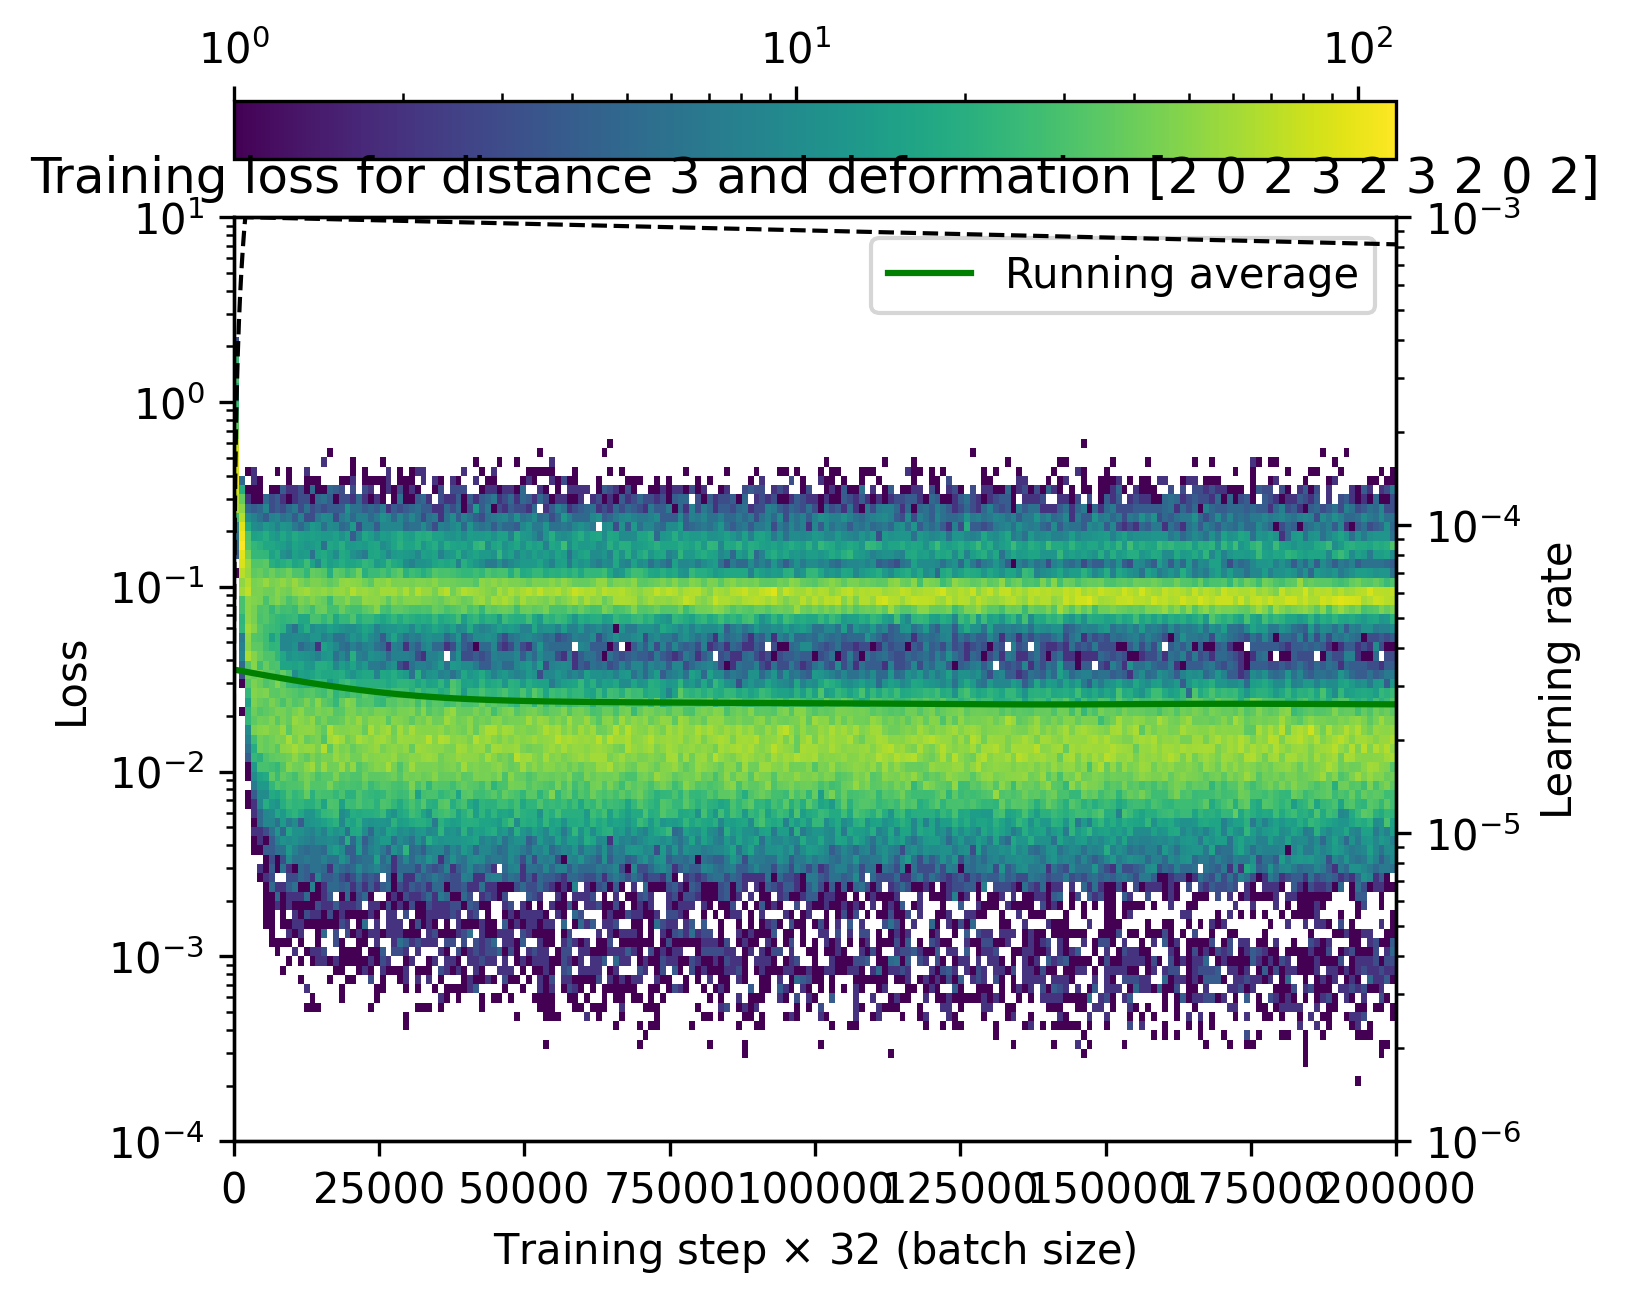

In [ ]:
sigma = 25_000

x = jnp.linspace(0, losses.shape[0]-1, 100)[:, None]
idx = jnp.arange(losses.shape[0])[None, :]
dist = jnp.exp(-(idx - x)**2 / sigma**2)
dist = dist / dist.sum(axis=1)[:, None]
running_avg = jnp.exp((dist * jnp.log(losses[None, :])).sum(axis=1))
# running_avg = (dist * losses[None, :]).sum(axis=1)

y_max = jnp.ceil(jnp.log10(losses).max()).astype(jnp.int32)
y_min = jnp.floor(jnp.log10(jnp.percentile(losses, .05))).astype(jnp.int32)
step = jnp.arange(losses.shape[0])
plt.figure(dpi=300, figsize=(5,5))
plt.hist2d(
    x=step, 
    y=losses, 
    bins=[
        jnp.linspace(0, losses.shape[0], 200),
        jnp.logspace(y_min, y_max, (y_max-y_min)*20+1)
    ],
    norm=LogNorm(vmin=1),
)
# plt.plot(step, losses, ',', alpha=.5)
plt.yscale('log')
plt.ylabel("Loss")
plt.xlabel(f"Training step $\\times$ {BATCH_SIZE} (batch size)")
plt.colorbar(location="top")
plt.plot(x[:,0], running_avg, '-g', label="Running average")
plt.legend(loc=1)

plt.twinx()
plt.plot(step, learning_rate(step), '--k', lw=1)
plt.yscale('log')
plt.ylabel("Learning rate")
plt.ylim(1E-6, 1E-3)

plt.xlim(0, losses.shape[0])

plt.title(f"Training loss for distance {CODE_DISTANCE} and deformation {DEFORMATION}")
# plt.savefig(f"figs/cnn_decoder_on_distance{CODE_DISTANCE}_deformation{''.join(str(d) for d in DEFORMATION)}.eps", bbox_inches='tight')
# plt.savefig(f"figs/cnn_decoder_on_distance{CODE_DISTANCE}_deformation{''.join(str(d) for d in DEFORMATION)}.png", bbox_inches='tight')

plt.show()

# Compare to other decoders

In [8]:
data_key = random.key(42)
p, nu = .01, 500
ERROR_PROBS = jnp.array([
    1 / (2 * (nu + 1)) * p,
    1 / (2 * (nu + 1)) * p,
    nu / (nu + 1) * p,
])

In [9]:
def get_data(
    data_key,
    batch_size: int,
    parity_info: tuple[jnp.ndarray],
) -> tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray, any]:
    data_key = random.split(data_key, num=batch_size+1)
    errors = vmap(
        code.error,
        in_axes=(0, None),
        out_axes=0
    )(data_key[:-1], ERROR_PROBS)
    imgs, logicals = vmap(
        code.syndrome_img,
        in_axes=(0, None),
        out_axes=0
    )(errors, parity_info)
    print(errors.shape)
    syndromes, _ = vmap(
        code.syndrome,
        in_axes=(0, None),
        out_axes=0
    )(errors, parity_info)
    return imgs[:,None,:,:], syndromes, logicals, data_key[-1]

def logicals_of_recovery(
    recovery: jnp.ndarray,
    parity_info: tuple[jnp.ndarray],
) -> jnp.ndarray:
    _, logicals = vmap(
        code.syndrome,
        in_axes=(0, None),
        out_axes=0
    )(recovery, parity_info)
    return logicals

In [10]:
parity_info = code.deformation_parity_info(DEFORMATION)
deformation_img = code.deformation_image(DEFORMATION)[None,:,:,:]
print(DEFORMATION.reshape(CODE_DISTANCE, CODE_DISTANCE))

[[2 0 2]
 [3 2 3]
 [2 0 2]]


In [11]:
imgs, syndromes, logicals, data_key = get_data(
    data_key, 
    batch_size=1_000_000, 
    parity_info=parity_info
)

(1000000, 2, 9)


NN-model decoder

In [12]:
nn_logicals = (nn.sigmoid(
    model.apply_batch(model_params, imgs)
) > .5).astype(jnp.int32)

i = 2 * logicals[:, 0] + logicals[:, 1]
j = 2 * nn_logicals[:, 0] + nn_logicals[:, 1]
nn_hist = jnp.zeros((4, 4), dtype=int).at[j, i].add(1)

MWPM decoder

In [13]:
def deform_recovery_batch(
    recovery = jnp.ndarray,
):
    def _deform_recovery(
        recovery: jnp.ndarray,
    ):
        inv_transformations = jnp.array([
            [[1, 0], [0, 1]],  # I
            [[1, 1], [0, 1]],  # X-Y
            [[1, 0], [1, 1]],  # Y-Z
            [[0, 1], [1, 0]],  # X-Z
            [[0, 1], [1, 1]],  # X-Y-Z
            [[1, 1], [1, 0]],  # X-Z-Y
        ])

        recovery_deformed = vmap(
            lambda A, B, Di: jnp.dot(Di, jnp.stack([A, B])) % 2,
            in_axes=(0, 0, 0),
            out_axes=1
        )(
            recovery[0],
            recovery[1],
            inv_transformations[DEFORMATION]
        )

        return recovery_deformed
    
    return vmap(_deform_recovery)(recovery)

# Decodes the un-deformed surface code and then deforms the recovery operation
matcher = Matching(
    jnp.append(code.hx_original, code.hz_original, axis=1)
)
recovery = matcher.decode_batch(syndromes)
recovery = recovery.reshape((recovery.shape[0], 2, recovery.shape[1]//2))
recovery = deform_recovery_batch(recovery)
mwpm_logicals = logicals_of_recovery(recovery, parity_info)

i = 2 * logicals[:, 0] + logicals[:, 1]
j = 2 * mwpm_logicals[:, 0] + mwpm_logicals[:, 1]
mwpm_hist = jnp.zeros((4, 4), dtype=int).at[j, i].add(1)

Perfect maximum likelihood decoder

In [14]:
# The PML decoder can't handle codes with a lot of qubits
if CODE_DISTANCE == 3:
    perfect_decoder = PMLD(code, ERROR_PROBS, parity_info)
    pml_logicals = perfect_decoder.decode_batch(syndromes)

    i = 2 * logicals[:, 0] + logicals[:, 1]
    j = 2 * pml_logicals[:, 0] + pml_logicals[:, 1]
    pml_hist = jnp.zeros((4, 4), dtype=int).at[j, i].add(1)
else:
    pml_hist = jnp.zeros((4,4))

### Compare

9
5.5015087e-05


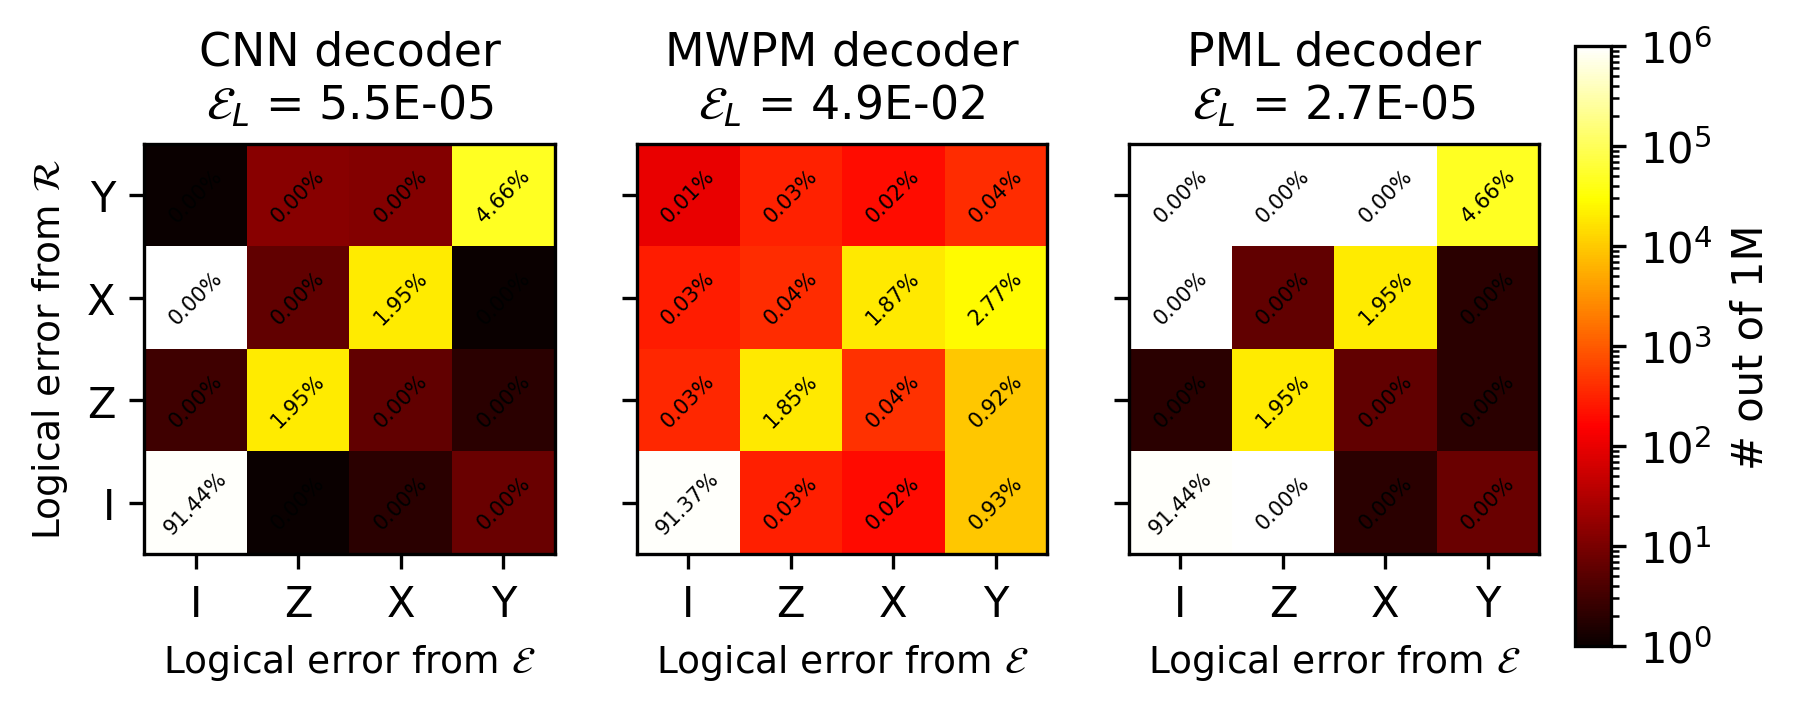

[2 0 2 3 2 3 2 0 2]


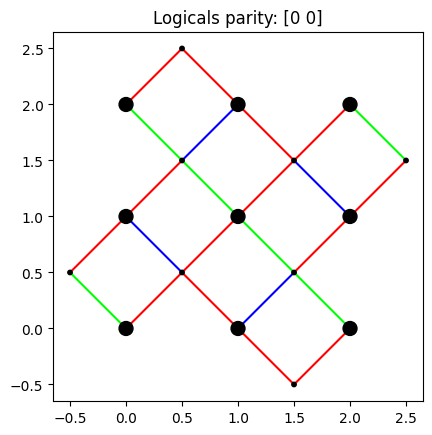

% Draw the plaquettes
\filldraw[fill=black!10, draw=none] (0,0) -- (2,0) -- (2,2) -- (0,2) -- cycle;
\filldraw[fill=black!5, draw=none] (0,2) -- (2,2) -- (2,4) -- (0,4) -- cycle;
\filldraw[fill=black!5, draw=none] (2,0) -- (4,0) -- (4,2) -- (2,2) -- cycle;
\filldraw[fill=black!10, draw=none] (2,2) -- (4,2) -- (4,4) -- (2,4) -- cycle;
\filldraw[fill=black!5, draw=none] (0,0) -- (0,2) -- (-1,1) -- cycle;
\filldraw[fill=black!5, draw=none] (4,2) -- (4,4) -- (5,3) -- cycle;
\filldraw[fill=black!10, draw=none] (2,0) -- (4,0) -- (3,-1) -- cycle;
\filldraw[fill=black!10, draw=none] (0,4) -- (2,4) -- (1,5) -- cycle;

% Draw the data qubits
\node[draw, circle, fill=BrickRed, line width=.5mm, minimum size=5mm] (D0) at (0.0,0.0) {};
\node[draw, circle, fill=White, line width=.5mm, minimum size=5mm] (D1) at (2.0,0.0) {};
\node[draw, circle, fill=BrickRed, line width=.5mm, minimum size=5mm] (D2) at (4.0,0.0) {};
\node[draw, circle, fill=Cerulean, line width=.5mm, minimum size=5mm] (D3) at (0.0,2.0)

In [15]:
# labels = ['0 0\nI', '0 1\nZ', '1 0\nX', '1 1\nY']
labels = ['I', 'Z', 'X', 'Y']

plot: tuple[plt.Figure, list[plt.Axes]] = plt.subplots(ncols=3, sharey=True)
fig, axs = plot
fig.set_figwidth(6)
fig.set_figheight(2)
fig.set_dpi(300)
axs[0].set_ylabel(f'Logical error from $\\mathcal{{R}}$', fontsize=9)
for ax, hist, name in zip(
    axs,
    [nn_hist, mwpm_hist, pml_hist],
    ["CNN", "MWPM", "PML"]
):
    img = ax.imshow(
        hist, 
        origin='lower', 
        cmap='hot',
        # vmin=0,
        # vmax=hist.sum(),
        norm=LogNorm(vmin=1, vmax=1E6)
    )
    ax.set_xticks(range(4), labels)
    ax.set_yticks(range(4), labels)
    ax.set_xlabel(f'Logical error from $\\mathcal{{E}}$', fontsize=9)
    for x, row in enumerate(jnp.array(hist).T):
        for y, count in enumerate(row):
            ax.text(x, y, f'{count/hist.sum():.2%}', ha='center', va='center', rotation=45, rotation_mode='anchor', fontsize=5)
    ax.set_title(f'{name} decoder\n$\\mathcal{{E}}_L$ = {1 - hist.diagonal().sum() / hist.sum():.1E}', fontsize=11)
cbar = fig.colorbar(img, cax=fig.add_axes((.92,0,.02,1)))
cbar.set_label("# out of 1M")

# plt.savefig(f"figs/decoder_comparison_distance{CODE_DISTANCE}_deformation{''.join(str(d) for d in DEFORMATION)}.eps", bbox_inches='tight', dpi=300)
# plt.savefig(f"figs/decoder_comparison_distance{CODE_DISTANCE}_deformation{''.join(str(d) for d in DEFORMATION)}.png", bbox_inches='tight', dpi=300)

print(ERROR_PROB_TRAINING_SCALE)
print(1 - nn_hist.diagonal().sum() / nn_hist.sum())
plt.show()

print(DEFORMATION)
code.show(parity_info)
print(code.show_latex_code(parity_info, DEFORMATION))